# Data augmentation

FMML Module 1, Lab 3<br>
 Module Coordinator: Thrupthi Ann John thrupthi.ann@research.iiit.ac.in <br>
 Release date: 18 October 2021 <br>

 In this lab, we will see how augmentation of data samples help in improving the machine learning performance

In [61]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
# set randomseed
rng = np.random.default_rng(seed=42)
from sklearn.utils.extmath import cartesian
from skimage.transform import rotate, AffineTransform, warp
import math

from skimage.filters import gaussian

Augmentation is useful when we have less training data available. Augmentation allows us to 'create' a larger dataset programatically. 

For this lab we will use a subset of MNIST that is very small, to better understand the effect of augmentation. 

In [2]:
#loading the dataset
(train_X, train_y), (test_X, test_y) = mnist.load_data()
train_X = train_X/255
test_X = test_X/255

train_X = train_X[::1200,:,:].copy() # subsample. Otherwise it will take too long!
train_y = train_y[::1200].copy() # do the same to the labels


11501568/11490434 [==============================] - 0s 0us/step


(50, 28, 28)

Let us borrow a few functions from the previous labs:

In [3]:
def NN1(traindata, trainlabel, query):
  diff  = traindata - query  # find the difference between features. Numpy automatically takes care of the size here 
  sq = diff*diff # square the differences
  dist = sq.sum(1) # add up the squares
  label = trainlabel[np.argmin(dist)] # our predicted label is the label of the training data which has the least distance from the query
  return label

def NN(traindata, trainlabel, testdata):
  # we will run nearest neighbour for each sample in the test data 
  # and collect the predicted classes in an array using list comprehension
  traindata = traindata.reshape(-1, 28*28)
  testdata = testdata.reshape(-1,28*28)
  predlabel = np.array([NN1(traindata, trainlabel, i) for i in testdata])
  return predlabel

def Accuracy(gtlabel, predlabel):
  assert len(gtlabel)==len(predlabel), "Length of the groundtruth labels and predicted labels should be the same"
  correct = (gtlabel==predlabel).sum() # count the number of times the groundtruth label is equal to the predicted label.
  return correct/len(gtlabel)

In this lab, we will use the image pixels themselves as features, instead of extracting features. Each image has 28*28 pixels, so we will flatten them to 784 pixels to use as features. Note that this is very compute intensive and will take a long time.<br>

Let us check the baseline accuracy on the test set without any augmentations. We hope that adding augmentations will help us to get better results.

In [150]:
testpred = NN(train_X, train_y, test_X)
print('Baseline accuracy without augmentation is ', Accuracy(test_y, testpred))

Baseline accuracy without augmentation is  0.6472


In [151]:
train_X.shape

(50, 28, 28)

Let us try to improve this accuracy using augmentations. When we create augmentations, we have to make sure that the changes reflect what will naturally occur in the dataset. For example, we should not add colour to our samples as an augmentation because they do not naturally occur. We should not also flip the images in MNIST, because flipped images have different meanings for digits. 

### Augmentation 1: rotation

Let us try rotating the image a little. We will use skimage library for this. 

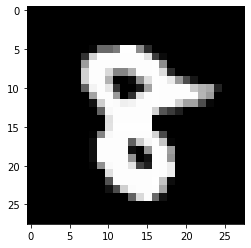

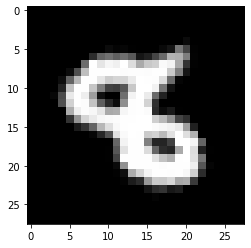

In [6]:
plt.imshow(train_X[2], cmap='gray')
plt.show()
plt.imshow(rotate(train_X[2],35), cmap='gray') # previously the angle was 45 degrees

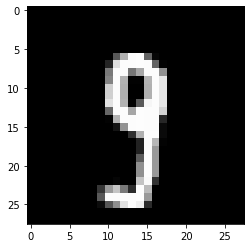

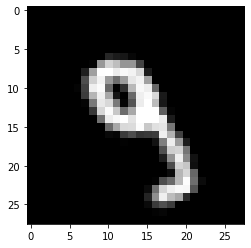

In [10]:
plt.imshow(train_X[6], cmap='gray')
plt.show()
plt.imshow(rotate(train_X[6],35), cmap='gray') # previously the angle was 45 degrees

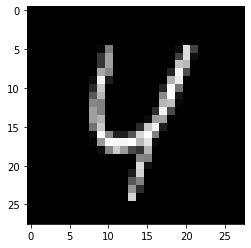

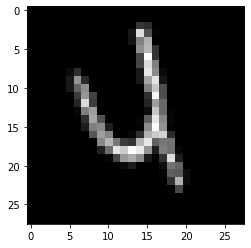

In [22]:
plt.imshow(train_X[7], cmap='gray')
plt.show()
plt.imshow(rotate(train_X[7],35), cmap='gray') # previously the angle was 45 degrees

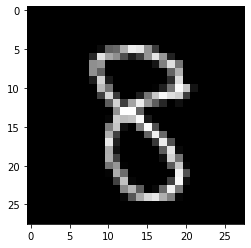

In [19]:
plt.imshow(train_X[3], cmap='gray')

After rotating, the the class of the image is still the same. Let us make a function to rotate multiple images by random angles. We want a slightly different image every time we run this function. So, we generate a random number between 0 and 1 and change it so that it lies between -constraint/2 and +constraint/2

In [23]:
def augRotate(sample, angleconstraint):
  if angleconstraint==0:
    return sample
  if len(sample.shape)==2:
    sample = np.expand_dims(sample, 0)  # make sure the sample is 3 dimensional
  angle = rng.random(len(sample)) # generate random numbers for angles
  angle = (angle-0.5)*angleconstraint # make the random angle constrained
  nsample = sample.copy() # preallocate the augmented array to make it faster
  for ii in range(len(sample)):
    nsample[ii] = rotate(sample[ii], angle[ii])
  return np.squeeze(nsample) # take care if the input had only one sample.

This function returns a slightly different image each time we call it. So we can increase the number of images in the sample by any multiple. 

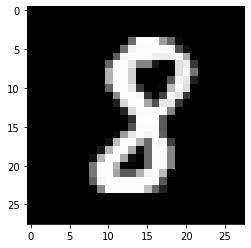

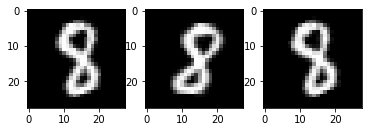

In [8]:
sample = train_X[20]
angleconstraint = 70
# show the original image
plt.imshow(sample, cmap='gray')
plt.show()
plt.subplot(1,3,1)
plt.imshow(augRotate(sample, angleconstraint), cmap='gray') # show an augmented image
plt.subplot(1,3,2)
plt.imshow(augRotate(sample, angleconstraint), cmap='gray') # show another augmented image from the same sample
plt.subplot(1,3,3)
plt.imshow(augRotate(sample, angleconstraint), cmap='gray') # one more image from the same sample

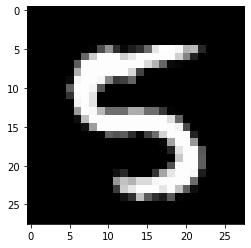

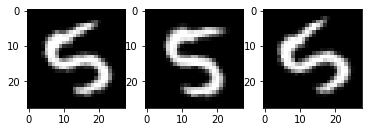

In [24]:
sample = train_X[45]
angleconstraint = 70
# show the original image
plt.imshow(sample, cmap='gray')
plt.show()
plt.subplot(1,3,1)
plt.imshow(augRotate(sample, 50), cmap='gray') # show an augmented image
plt.subplot(1,3,2)
plt.imshow(augRotate(sample, 60), cmap='gray') # show another augmented image from the same sample
plt.subplot(1,3,3)
plt.imshow(augRotate(sample, angleconstraint), cmap='gray') # one more image from the same sample

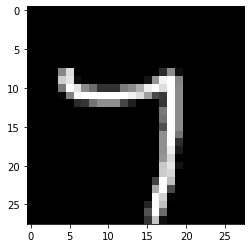

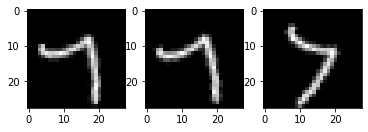

In [28]:
sample = train_X[38]
angleconstraint = 70
# show the original image
plt.imshow(sample, cmap='gray')
plt.show()
plt.subplot(1,3,1)
plt.imshow(augRotate(sample, 50), cmap='gray') # show an augmented image
plt.subplot(1,3,2)
plt.imshow(augRotate(sample, 60), cmap='gray') # show another augmented image from the same sample
plt.subplot(1,3,3)
plt.imshow(augRotate(sample, angleconstraint), cmap='gray') # one more image from the same sample

Let us augment the whole dataset and see if this improves the test accuracy

In [29]:
# hyperparameters
angleconstraint = 60
naugmentations = 5

# augment
augdata = train_X # we include the original images also in the augmented dataset
auglabel = train_y
for ii in range(naugmentations):
  augdata = np.concatenate((augdata, augRotate(train_X, angleconstraint))) # concatenate the augmented data to the set
  auglabel = np.concatenate((auglabel, train_y))  # the labels don't change when we augment

# check the test accuracy
testpred = NN(augdata, auglabel, test_X)
print('Accuracy after rotation augmentation is ', Accuracy(test_y, testpred))

Accuracy after rotation augmentation is  0.6743


In [108]:
# hyperparameters
#angleconstraint = 55
#naugmentations =25

# augment
augdata = train_X # we include the original images also in the augmented dataset
auglabel = train_y
for ii in range(0,7):
  augdata = np.concatenate((augdata, augRotate(train_X, ii*10))) # concatenate the augmented data to the set
  auglabel = np.concatenate((auglabel, train_y))  # the labels don't change when we augment

# check the test accuracy
testpred = NN(augdata, auglabel, test_X)
print('Accuracy after rotation augmentation is ', Accuracy(test_y, testpred))

Accuracy after rotation augmentation is  0.6755


In [40]:
train_X.shape

(50, 28, 28)

In [41]:
augdata.shape

(400, 28, 28)

The angle constraint is a hyperparameter which we have to tune using a validation set. (Here we are not doing that for time constraints). Let us try a grid search to find the best angle constraint.

In [117]:
angleconstraints = [5,10,15,20,25,30,35,40,45,50,55,60] # the values we want to test
accuracies = np.zeros(len(angleconstraints), dtype=np.float) # we will save the values here
naugmentations = 15
for ii in range(len(angleconstraints)):
  # create the augmented dataset
  augdata1 = train_X # we include the original images also in the augmented dataset
  auglabel1 = train_y
  for jj in range(naugmentations):
    augdata1 = np.concatenate((augdata1, augRotate(train_X, angleconstraints[ii]))) # concatenate the augmented data to the set
    auglabel1 = np.concatenate((auglabel1, train_y))  # the labels don't change when we augment

  # check the test accuracy
  testpred = NN(augdata1, auglabel1, test_X)
  accuracies[ii] = Accuracy(test_y, testpred)
  print('Accuracy after rotation augmentation constrained by ',angleconstraints[ii], ' is ', accuracies[ii], flush=True)



Accuracy after rotation augmentation constrained by  5  is  0.6631
Accuracy after rotation augmentation constrained by  10  is  0.6765
Accuracy after rotation augmentation constrained by  15  is  0.6813
Accuracy after rotation augmentation constrained by  20  is  0.6878
Accuracy after rotation augmentation constrained by  25  is  0.6891
Accuracy after rotation augmentation constrained by  30  is  0.6871
Accuracy after rotation augmentation constrained by  35  is  0.6877
Accuracy after rotation augmentation constrained by  40  is  0.6871
Accuracy after rotation augmentation constrained by  45  is  0.6793
Accuracy after rotation augmentation constrained by  50  is  0.6838
Accuracy after rotation augmentation constrained by  55  is  0.6814
Accuracy after rotation augmentation constrained by  60  is  0.6804


In [46]:
augdata.shape

(300, 28, 28)

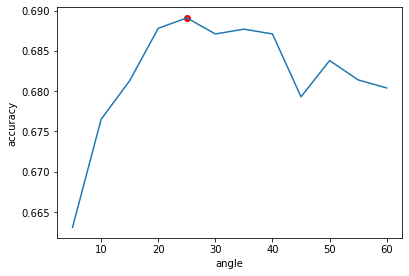

In [118]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # main axes
# plot the variation of accuracy
ax.plot(angleconstraints, accuracies)
ax.set_xlabel('angle')
ax.set_ylabel('accuracy')
# plot the maximum accuracy
maxind = np.argmax(accuracies)
plt.scatter(angleconstraints[maxind], accuracies[maxind], c='red')

Let us see the best value for angle constraint: (Ideally this should be done on validation set, not test set)

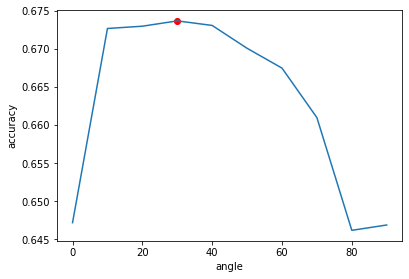

In [11]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # main axes
# plot the variation of accuracy
ax.plot(angleconstraints, accuracies)
ax.set_xlabel('angle')
ax.set_ylabel('accuracy')
# plot the maximum accuracy
maxind = np.argmax(accuracies)
plt.scatter(angleconstraints[maxind], accuracies[maxind], c='red')

Text(0.5, 1.0, 'Blurred Image')

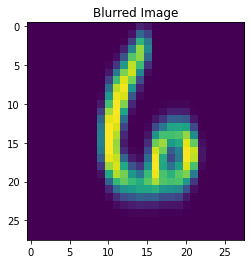

In [72]:
blurred = gaussian(train_X[32],sigma=1.2,multichannel=True)

plt.imshow(blurred)
plt.title('Blurred Image')

In [123]:
sigma = [0.2, 0.25,0.3, 0.35, 0.4, 0.45, 0.5, 0.55]# the values we want to test
accuracies = np.zeros(len(angleconstraints), dtype=np.float) # we will save the values here
naugmentations = 15
for ii in range(len(sigma)):
  # create the augmented dataset
  augdata2 = train_X # we include the original images also in the augmented dataset
  auglabel2 = train_y
  for jj in range(naugmentations):
    augdata2 = np.concatenate((augdata2, gaussian(train_X,sigma[ii],multichannel=True))) # concatenate the augmented data to the set
    auglabel2 = np.concatenate((auglabel2, train_y))  # the labels don't change when we augment

  # check the test accuracy
  testpred = NN(augdata2, auglabel2, test_X)
  accuracies[ii] = Accuracy(test_y, testpred)
  print('Accuracy after Blurred constrained by ',sigma[ii], ' is ', accuracies[ii], flush=True)



Accuracy after Blurred constrained by  0.2  is  0.6472
Accuracy after Blurred constrained by  0.25  is  0.6472
Accuracy after Blurred constrained by  0.3  is  0.6475
Accuracy after Blurred constrained by  0.35  is  0.6486
Accuracy after Blurred constrained by  0.4  is  0.6522
Accuracy after Blurred constrained by  0.45  is  0.6548
Accuracy after Blurred constrained by  0.5  is  0.6559
Accuracy after Blurred constrained by  0.55  is  0.6537


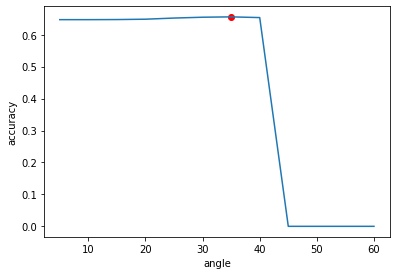

In [124]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # main axes
# plot the variation of accuracy
ax.plot(angleconstraints, accuracies)
ax.set_xlabel('angle')
ax.set_ylabel('accuracy')
# plot the maximum accuracy
maxind = np.argmax(accuracies)
plt.scatter(angleconstraints[maxind], accuracies[maxind], c='red')

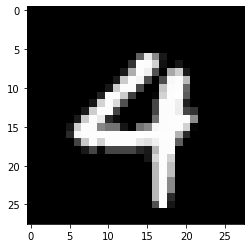

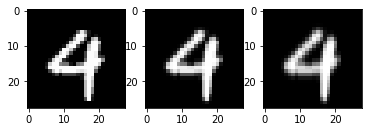

In [81]:
sample = train_X[15]

plt.imshow(sample, cmap='gray')
plt.show()
plt.subplot(1,3,1)
plt.imshow(gaussian(sample, sigma = 0.25,multichannel=True), cmap='gray') # show an augmented image
plt.subplot(1,3,2)
plt.imshow(gaussian(sample, sigma = 0.5, multichannel=True), cmap='gray') # show another augmented image from the same sample
plt.subplot(1,3,3)
plt.imshow(gaussian(sample, sigma = 0.75, multichannel=True), cmap='gray') # one more image from the same sample

Let us try one more augmentation: shear. Here is what this looks like:

In [126]:
def shear(sample, amount):
  tform = AffineTransform(shear = amount) # create the shear transform
  img = warp(sample, tform) # apply the shear
  # this makes the digit off-center. Since all the images in the test set are centralized, we will do the same here
  col = img.sum(0).nonzero()[0]
  row = img.sum(1).nonzero()[0]
  if len(col)>0 and len(row)>0:
    xshift = int(sample.shape[0]/2 - (row[0]+row[-1])/2)
    yshift = int(sample.shape[1]/2 - (col[0]+col[-1])/2)
    img = np.roll(img, (xshift, yshift),(0,1))
  return img

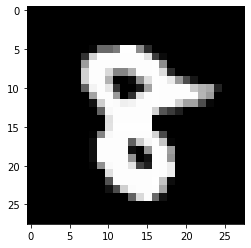

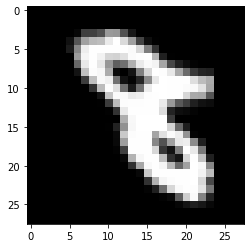

In [16]:
sample = train_X[2]
plt.imshow(sample, cmap='gray')
plt.show()

# apply shear
plt.imshow(shear(sample, 0.4), cmap='gray')

Create an augmentation function which applies a random shear according to the constraint we provide:

In [127]:
def augShear(sample, shearconstraint):
  if shearconstraint==0:
    return sample
  if len(sample.shape)==2:
    sample = np.expand_dims(sample, 0)  # make sure the sample is 3 dimensional
  amt = rng.random(len(sample)) # generate random numbers for shear
  amt = (amt-0.5)*shearconstraint # make the random shear constrained
  nsample = sample.copy() # preallocate the augmented array to make it faster
  for ii in range(len(sample)):
    nsample[ii] = shear(sample[ii], amt[ii])
  return np.squeeze(nsample) # take care if the input had only one sample.

Let us do a grid search to find the best shear constraint.

In [129]:
shearconstraints = [0, 0.2,0.4,0.6,0.8,1.0,1.2,1.4] # the values we want to test
accuracies = np.zeros(len(shearconstraints), dtype=np.float) # we will save the values here

for ii in range(len(shearconstraints)):
  # create the augmented dataset
  augdata3 = train_X # we include the original images also in the augmented dataset
  auglabel3 = train_y
  for jj in range(naugmentations):
    augdata3 = np.concatenate((augdata3, augShear(train_X, shearconstraints[ii]))) # concatenate the augmented data to the set
    auglabel3 = np.concatenate((auglabel3, train_y))  # the labels don't change when we augment

  # check the test accuracy
  testpred = NN(augdata3, auglabel3, test_X)
  accuracies[ii] = Accuracy(test_y, testpred)
  print('Accuracy after shear augmentation constrained by ',shearconstraints[ii], ' is ', accuracies[ii], flush=True)

Accuracy after shear augmentation constrained by  0  is  0.6472
Accuracy after shear augmentation constrained by  0.2  is  0.6189
Accuracy after shear augmentation constrained by  0.4  is  0.64
Accuracy after shear augmentation constrained by  0.6  is  0.6486
Accuracy after shear augmentation constrained by  0.8  is  0.6608
Accuracy after shear augmentation constrained by  1.0  is  0.6571
Accuracy after shear augmentation constrained by  1.2  is  0.6577
Accuracy after shear augmentation constrained by  1.4  is  0.637


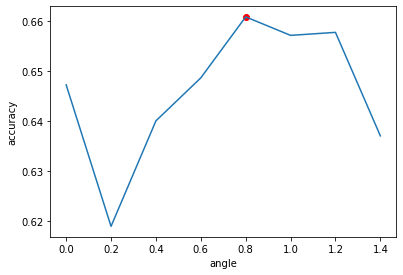

In [130]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # main axes
# plot the variation of accuracy
ax.plot(shearconstraints, accuracies)
ax.set_xlabel('angle')
ax.set_ylabel('accuracy')
# plot the maximum accuracy
maxind = np.argmax(accuracies)
plt.scatter(shearconstraints[maxind], accuracies[maxind], c='red')

In [143]:
augdata4 = np.concatenate((augdata1, augdata2, augdata3))
auglabel4= np.concatenate((auglabel1, auglabel2, auglabel3))
augdata4.shape

(2400, 28, 28)

In [ ]:
accuracies = np.zeros(len(hyp), dtype=np.float)
for j in range(len(augdata4):
    
  testpred = NN(augdata, auglabel, test_X)
  accuracies[ii] = Accuracy(test_y, testpred)
  print('Accuracy augmentation is ', accuracies[ii], flush=True)

We can do multiple augmentations at the same time. Here is a function to do both shear and rotation to the sample. In this case, we will have two hyperparameters. 

In [20]:
def augRotateShear(sample, angleconstraint, shearconstraint):
  if len(sample.shape)==2:
    sample = np.expand_dims(sample, 0)  # make sure the sample is 3 dimensional
  amt = rng.random(len(sample)) # generate random numbers for shear
  amt = (amt-0.5)*shearconstraint # make the random shear constrained
  angle = rng.random(len(sample)) # generate random numbers for angles
  angle = (angle-0.5)*angleconstraint # make the random angle constrained
  nsample = sample.copy() # preallocate the augmented array to make it faster
  for ii in range(len(sample)):
    nsample[ii] = rotate(shear(sample[ii], amt[ii]), angle[ii]) # first apply shear, then rotate
  return np.squeeze(nsample) # take care if the input had only one sample.

Since we have two hyperparameters, we have to do the grid search on a 2 dimensional matrix. We can use our previous experience to inform where to search for the best hyperparameters. 

In [145]:
shearconstraints = [0, 0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6] # the values we want to test
angleconstraints = [0,10,20,30,40,50,60] # the values we want to test
hyp = cartesian((shearconstraints, angleconstraints)) # cartesian product of both

accuracies = np.zeros(len(hyp), dtype=np.float) # we will save the values here

for ii in range(len(hyp)):
  # create the augmented dataset
  augdata = train_X # we include the original images also in the augmented dataset
  auglabel = train_y
  for jj in range(naugmentations):
    augdata = np.concatenate((augdata, augRo auglabel = np.concatenate((auglabel, train_y))tateShear(train_X, hyp[ii][0], hyp[ii][1]))) # concatenate the augmented data to the set
     # the labels don't change when we augment

  # check the test accuracy
  testpred = NN(augdata, auglabel, test_X)
  accuracies[ii] = Accuracy(test_y, testpred)
  print('Accuracy after augmentation shear:',hyp[ii][0], 'angle:',hyp[ii][1], ' is ', accuracies[ii], flush=True)

SyntaxError: ignored

In [148]:
testpred = NN(augdata4, auglabel4, test_X)
print('Accuracy after rotation shear blur augmentation is ', Accuracy(test_y, testpred))

Accuracy after rotation augmentation is  0.6953


In [97]:

shearconstraints = [0, 0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6] # the values we want to test
angleconstraints = [0,10,20,30,40,50,60] # the values we want to test
hyp = cartesian((shearconstraints, angleconstraints)) # cartesian product of both

accuracies = np.zeros(len(hyp), dtype=np.float) # we will save the values here

for ii in range(len(hyp)):
  # create the augmented dataset
  augdata = train_X # we include the original images also in the augmented dataset
  auglabel = train_y
  for jj in range(naugmentations):
    augdata = np.concatenate((augdata, augRo auglabel = np.concatenate((auglabel, train_y))tateShear(train_X, hyp[ii][0], hyp[ii][1]))) # concatenate the augmented data to the set
     # the labels don't change when we augment

  # check the test accuracy
  testpred = NN(augdata, auglabel, test_X)
  accuracies[ii] = Accuracy(test_y, testpred)
  print('Accuracy after augmentation shear:',hyp[ii][0], 'angle:',hyp[ii][1], ' is ', accuracies[ii], flush=True)



In [98]:
from tqdm import tqdm
from skimage.util import random_noise
aug_train_data = []
aug_target_train = []
for i in range(len(train_X)):
    aug_train_data.append(train_X[i])
    aug_target_train.append(train_y)
    aug_train_data.append(rotate(train_X[i], angle=45, mode = 'wrap'))
    aug_target_train.append(train_y)
    aug_train_data.append(np.fliplr(train_X[i]))
    aug_target_train.append(train_y)
    aug_train_data.append(np.flipud(train_X[i]))
    aug_target_train.append(train_y)
    aug_train_data.append(random_noise(train_X[i],var=0.2**2))
    aug_target_train.append(train_y)

AttributeError: ignored

Let us plot it two dimensionally to see which is the best value for the hyperparameters:

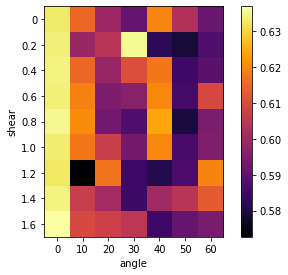

In [22]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # main axes
im = ax.imshow(accuracies.reshape((len(shearconstraints), len(angleconstraints))), cmap='inferno') 
ax.set_xlabel('angle')
ax.set_ylabel('shear')
ax.set_xticks(np.arange(len(angleconstraints)));
ax.set_xticklabels(angleconstraints);
ax.set_yticks(np.arange(len(shearconstraints)));
ax.set_yticklabels(shearconstraints);
plt.colorbar(im)

It seems that rotation and shear don't mix! The best accuracy is when rotation is zero.

## Questions
Try these questions for better understanding. You may not be able to solve all of them. 
1. What is the best value for angle constraint and shear constraint you got? How much did the accuracy improve as compared to not using augmentations?
2. Can you increase the accuracy by increasing the number of augmentations from each sample?
3. Try implementing a few augmentations of your own and experimenting with them. A good reference is <a href=https://www.analyticsvidhya.com/blog/2019/12/image-augmentation-deep-learning-pytorch/>here. </a>
4. Try combining various augmentations. What is the highest accuracy you can get? What is the smallest training dataset you can take and still get accuracy above 50%?

Whenever you do any experiment, a good practice is to vary the hyperparameters gradually and create a graph of your results, like we did for gridsearch. 

In [ ]:
What is the best value for angle constraint and shear constraint you got? How much did the accuracy improve as compared to not using augmentations?
shear = 0.8, angle = 25. Basline accuracy was 64.7% it improved to 69.7%

Can you increase the accuracy by increasing the number of augmentations from each sample?
yes

Try implementing a few augmentations of your own and experimenting with them. A good reference is here.
Applied burred constraint and saw the accuracy was increased a bit 

Try combining various augmentations. What is the highest accuracy you can get? What is the smallest training dataset you can take and still get accuracy above 50%?
Combaining angle, shear and blurred constraints got accuracies of 69.7%. 50 observations which was taken to check the baseline accuracy can be the smallest training dataset
target accuracy more than 50%